In [10]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable

# Local imports
import utils.utils as utils

# For data loader
import prep_dataset.prep_cityscapes_dataset as prep_cityscapes_dataset

# For model
from modules.CASENet import CASENet_resnet101

# For training and validation
import train_val.model_play as model_play


# For settings
import config




In [3]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable

# Local imports
import utils.utils as utils

# For data loader
import prep_dataset.prep_cityscapes_dataset as prep_cityscapes_dataset

# For model
from modules.CASENet import CASENet_resnet101

# For training and validation
import train_val.model_play as model_play

# For visualization
import visdom
viz = visdom.Visdom(env='CASENet')

# For settings
import config

args = config.get_args()
def main():
    global args
    
    print("config:{0}".format(args))
    print("OK")

    checkpoint_dir = args.checkpoint_folder

    global_step = 0
    min_val_loss = 999999999

    title = 'train|val loss '
    init = np.NaN
    win_feats5 = viz.line(
        X=np.column_stack((np.array([init]), np.array([init]))),
        Y=np.column_stack((np.array([init]), np.array([init]))),
        opts={'title': title, 'xlabel': 'Iter', 'ylabel': 'Loss', 'legend': ['train_feats5', 'val_feats5']},
    )
    
    win_fusion = viz.line(
        X=np.column_stack((np.array([init]), np.array([init]))),
        Y=np.column_stack((np.array([init]), np.array([init]))),
        opts={'title': title, 'xlabel': 'Iter', 'ylabel': 'Loss', 'legend': ['train_fusion', 'val_fusion']},
    )
    
    win_right = viz.line(
        X=np.column_stack((np.array([init]), np.array([init]))),
        Y=np.column_stack((np.array([init]), np.array([init]))),
        opts={'title': title, 'xlabel': 'Iter', 'ylabel': 'Loss', 'legend': ['train_feats5', 'val_feats5']},
    )

    train_loader, val_loader = prep_cityscapes_dataset.get_dataloader(args)
    model = CASENet_resnet101(pretrained=False, num_classes=args.cls_num)

    if args.multigpu:
        model = torch.nn.DataParallel(model.cuda())
    else:
        model = model.cuda()

    policies = get_model_policy(model) # Set the lr_mult=10 of new layer
    #optimizer = torch.optim.SGD(policies, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    optimizer = torch.optim.Adam(policies, lr=args.lr, weight_decay=args.weight_decay)

    cudnn.benchmark = True

    
    if True:
        checkpoint = torch.load("./checkpoint/curr_checkpoint.pth.tar")
        args.start_epoch = checkpoint['epoch']+1
        min_val_loss = checkpoint['min_loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        del checkpoint
        torch.cuda.empty_cache()

    for epoch in range(1):
        torch.cuda.empty_cache()
       
        
        #print("jsdfahsjadkfhsjkadfhsjkdafhsjkdafhskdajfhskdajfhskdaj")
    
        curr_loss = model_play.validate(args, val_loader, model, epoch, win_feats5, win_fusion,win_right, viz, global_step)
        

def get_model_policy(model):
    score_feats_conv_weight = []
    score_feats_conv_bias = []
    other_pts = []
    for m in model.named_modules():
        if m[0] != '' and m[0] != 'module':
            if ('score' in m[0] or 'fusion' in m[0]) and isinstance(m[1], torch.nn.Conv2d):
                ps = list(m[1].parameters())
                score_feats_conv_weight.append(ps[0])
                if len(ps) == 2:
                    score_feats_conv_bias.append(ps[1])
                print("Totally new layer:{0}".format(m[0]))
            else: # For all the other module that is not totally new layer.
                ps = list(m[1].parameters())
                other_pts.extend(ps)

    return [
            {'params': score_feats_conv_weight, 'lr_mult': 10, 'name': 'score_conv_weight'},
            {'params': score_feats_conv_bias, 'lr_mult': 20, 'name': 'score_conv_bias'},
            {'params': filter(lambda p: p.requires_grad, other_pts), 'lr_mult': 1, 'name': 'other'},
    ]

if __name__ == '__main__':
    main()



Setting up a new session...
usage: ipykernel_launcher.py [-h] [--checkpoint-folder DIR] [--multigpu]
                             [-j N] [--epochs N] [--start-epoch N]
                             [--cls-num N] [--lr-steps LRSteps [LRSteps ...]]
                             [--acc-steps AccSteps] [-b N] [--lr L]
                             [--momentum M] [--weight-decay W]
                             [--print-freq N] [--resume-model PATH]
                             [--pretrained-model PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/ming/.local/share/jupyter/runtime/kernel-c35eef1b-a453-45b3-a666-0a462fa78a33.json


SystemExit: 2

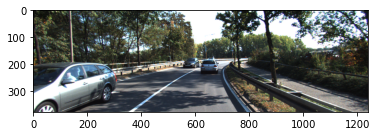

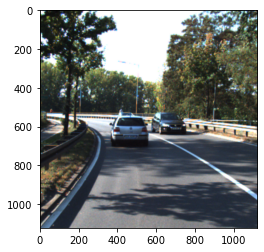

In [49]:
 
import time
 
import torch
 
from torchvision import transforms
import os
import random
import numpy as np
import copy
from PIL import Image  # using pillow-simd for increased speed

import torch
import torch.utils.data as data
from torchvision import transforms
import matplotlib.pyplot as plt

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
 

img = pil_loader('left.png')
plt.imshow(img)
plt.show()
w,h=img.size
transform1  = transforms.Compose([transforms.RandomResizedCrop(1122, scale=(0.75,1.0), ratio=(0.75,1.0)), transforms.RandomHorizontalFlip()])
a= transform1(img)
plt.imshow(a)
plt.show()

In [43]:
import os
import torch
a = torch.zeros(1, 5, 5).float()


print(a.mean())
print(1)

tensor(0.)
1


In [81]:
num_ch_enc=np.array([64, 64, 128, 256,512])
num_ch_dec = np.array([16, 32, 64, 128, 256])
for i in range(4):
    print(i)
for i in range(4, -1, -1):
    print(i)
    num_ch_in = num_ch_enc[-1] if i == 4 else num_ch_dec[i+1]
    num_ch_out = num_ch_dec[i]
    #print(num_ch_in,num_ch_out)

0
1
2
3
4
3
2
1
0


In [82]:
a =[]
a.append(2)
a.append(3)
print(a)

[2, 3]


In [85]:
if 3 in range(4):
    print("use")

use


In [ ]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import math
import torchvision.models as models
import sys
sys.path.append("../")

import numpy as np
import utils.utils as utils
import os
from collections import OrderedDict
from layers import *
inplanes = 16
conv1 = nn.Conv2d(num_input_images*3, 16, kernel_size=7, stride=1, padding=3,
                               bias=False)
bn_conv1 = nn.BatchNorm2d(16)
set_require_grad_to_false(self.bn_conv1)
relu = nn.ReLU(inplace=True)
maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
input_data = torch.rand(1, 3, 472, 472)
input_var = Variable(input_data)
print(input_data)


(1, 1, 256, 512)
tensor([[[[ True,  True,  True,  ...,  True,  True, False],
          [ True,  True, False,  ..., False,  True, False],
          [ True, False, False,  ..., False,  True, False],
          ...,
          [ True,  True,  True,  ..., False,  True, False],
          [ True,  True,  True,  ..., False,  True, False],
          [ True,  True,  True,  ...,  True,  True, False]]]])
[[ 8.2495295e-02  4.4526190e-02  5.2442737e-02 ...  7.7543943e-03
  -4.2715762e-03 -1.5402507e-04]
 [ 5.5194810e-02 -4.1389503e-03 -1.4579818e-03 ...  5.0860830e-04
  -6.9056982e-03 -2.4554619e-04]
 [ 4.8051853e-02 -3.9656088e-04  1.1062380e-03 ...  1.1963961e-03
  -7.0160381e-03 -2.4024339e-04]
 ...
 [ 7.1920043e-01 -6.8560779e-02 -9.6185803e-03 ...  7.6334504e-04
  -3.6544336e-03 -4.1044452e-05]
 [ 7.2573161e-01 -3.8500637e-02  2.7347609e-02 ... -1.4199255e-04
  -3.7295572e-03 -4.1903171e-05]
 [ 1.0562446e+00  5.1432395e-01  5.7771176e-01 ...  4.8656180e-03
  -2.4187632e-03 -2.7032060e-05]]
531.1

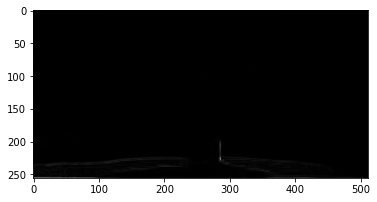

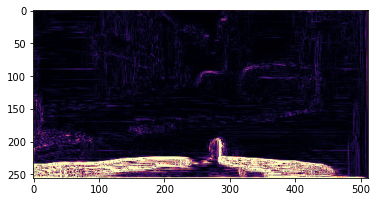

In [146]:
#求边缘
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
'''
im=Image.open('./Test_disparity.png').convert("L")
#plt.imshow(im)


#plt.show()
im = np.array(im, dtype='float32')
#print(im)

im1 = torch.from_numpy(im.reshape((2,1,im.shape[0]//2,im.shape[1])))
conv1 = nn.Conv2d(1,1,3,padding=1,bias=True)
sobel_kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],dtype='float32').reshape((1,1,3,3))
#print(sobel_kernel)
conv1.weight.data = torch.from_numpy(sobel_kernel)
edge1 = conv1(Variable(im1))
edge3 = conv1(Variable(im1))
#print(edge1.size())
#edge4=torch.stack((edge1, edge3), 0)
#print(edge1.size())

edge1 = edge3.data.squeeze().numpy()

edge2 = np.array((abs(edge1)>20).astype(int))
#edge3 = np.array((abs(edge1)).astype(int))


print(edge2.shape)
#print(np.uint8(edge3&edge2)*255)
#print((edge3&edge2).sum())
#edge4 = Image.fromarray(np.uint8(edge3&edge2))

plt.imshow(edge2.reshape(im.shape[0],im.shape[1]),cmap='gray')
plt.show()

'''
hh=np.load('h.npy')  #加载文件
print(hh.shape)
im1 = torch.from_numpy(hh.reshape((1,1,hh.shape[2],hh.shape[3])))
conv1 = nn.Conv2d(1,1,3,padding=1,bias=False)
sobel_kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],dtype='float32').reshape((1,1,3,3))
#print(sobel_kernel)
conv1.weight.data = torch.from_numpy(sobel_kernel)
edge1 = conv1(Variable(im1))
print((abs(edge1)>0.002))

edge2 = edge1.squeeze().data.numpy()

print(edge2)
print(abs(edge2).sum())
edge3 = np.array((abs(edge2)>0.002).astype(float))
#edge3 = np.array((abs(edge1)).astype(int))

edge3 = np.array((abs(edge2)))
print(edge3.min())
#print(np.uint8(edge3&edge2)*255)
#print((edge3&edge2).sum())
#edge4 = Image.fromarray(np.uint8(edge3&edge2))
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
plt.imshow(edge3*1000,cmap='gray')
plt.show()
vmax = np.percentile(edge3, 95)
normalizer = mpl.colors.Normalize(vmin=edge3.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
colormapped_im = (mapper.to_rgba(edge3)[:, :, :3] * 255).astype(np.uint8)
im = pil.fromarray(colormapped_im)
plt.imshow(im)
plt.show()

In [32]:
plt.imshow(edge2[1,:,:],cmap='gray')
plt.show()





IndexError: too many indices for array

In [71]:
from torchvision import transforms
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable

transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
def dis_loader(path):
    return Image.open(path)

def apply_disparity(img, disp):
        batch_size, height, width = img.size()
        #print(img.size())

        # Original coordinates of pixels
        x_base = torch.linspace(0, 1, width).repeat(batch_size,
                    height, 1)
        y_base = torch.linspace(0, 1, height).repeat(batch_size,
                    width, 1).transpose(1, 2)
        #print(x_base.size(),y_base.size())

        # Apply shift in X direction
        x_shifts = disp[:,  :, :]  # Disparity is passed in NCHW format with 1 channel
        #print(x_shifts)
        flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
        print(flow_field.size())
        # In grid_sample coordinates are assumed to be between -1 and 1
        output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear',
                               padding_mode='zeros')

        return output
c = pil_loader('left.png')
d = dis_loader('./Test_disparity_175.png')




a = (np.ascontiguousarray(d,dtype=np.float32)/256).astype(int)


#print(d.shape)
e=transform1((np.array(d)/256).astype(int))
print(e.max())
#dis=e.numpy()
#dis=transform1(dis)
#dis=np.array(a)
#print(dis.shape)

img=transform1(c)
print(img)
#d= transform1(d)
b=np.array(c)


#img = torch.from_numpy(b)

#dis = torch.from_numpy(dis)
print(img.size(),e.size())



output = apply_disparity(img,e)
print(output.sum())

tensor(126)
tensor([[[0.0667, 0.0706, 0.0706,  ..., 0.0745, 0.0706, 0.0863],
         [0.0196, 0.0157, 0.0314,  ..., 0.0784, 0.0784, 0.0784],
         [0.1216, 0.1333, 0.0902,  ..., 0.0784, 0.0784, 0.0784],
         ...,
         [0.7333, 0.4549, 0.3725,  ..., 0.6157, 0.5451, 0.5176],
         [0.6039, 0.2863, 0.2392,  ..., 0.6627, 0.6471, 0.6392],
         [0.5647, 0.2510, 0.2392,  ..., 0.6392, 0.6510, 0.6471]],

        [[0.0471, 0.0588, 0.0706,  ..., 0.1020, 0.1176, 0.1137],
         [0.0471, 0.0392, 0.0431,  ..., 0.0980, 0.0902, 0.0941],
         [0.0471, 0.0588, 0.0667,  ..., 0.0902, 0.0863, 0.0863],
         ...,
         [0.7804, 0.6745, 0.5098,  ..., 0.5804, 0.5725, 0.5490],
         [0.7137, 0.6039, 0.4275,  ..., 0.6235, 0.6157, 0.5922],
         [0.6392, 0.5137, 0.3412,  ..., 0.6667, 0.6431, 0.6118]],

        [[0.0314, 0.0392, 0.0392,  ..., 0.0784, 0.0863, 0.0902],
         [0.0431, 0.0510, 0.0549,  ..., 0.0824, 0.0941, 0.0902],
         [0.0510, 0.0510, 0.0549,  ..., 0.0863

RuntimeError: grid_sampler(): expected 4D or 5D input and grid with same number of dimensions, but got input with sizes [3, 376, 1241] and grid with sizes [3, 376, 1241, 2]

In [286]:
c = pil_loader('left.png')
a=torch.linspace(0, 1241-1, 1241).repeat(1,
                    376, 1).transpose(1, 2).type_as('uint8')
print(a)


TypeError: type_as(): argument 'other' (position 1) must be Tensor, not str

In [4]:
from torchvision import transforms
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable

transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)
def SSIM(x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')


a = pil_loader('left.png')
d = pil_loader('left.png')
a=transform1(np.array(a))
d=transform1(np.array(d))
print(SSIM(a,d).sum())



tensor(0.)


In [2]:
a=1221212
print("sss"+str(a)+'asf')

sss1221212asf


In [19]:
a=45643
a=a//10000
print(0.1**a)

0.00010000000000000002


In [20]:
def adjust_learning_rate(ori_lr, weight_decay, optimizer, global_step):
    #decay = 0.1 ** (sum(global_step >= np.array(lr_steps)))
    decay = 0.1 ** (global_step//10000)
    lr = ori_lr * decay
    decay = weight_decay
    for param_group in optimizer.param_groups:
        if 'lr_mult' in param_group:
            param_group['lr'] = lr * param_group['lr_mult']
        else:
            param_group['lr'] = lr

        if 'decay_mult' in param_group:
            param_group['weight_decay'] = decay * param_group['decay_mult']

    return lr

In [28]:
def get_model_policy(model):
    score_feats_conv_weight = []
    score_feats_conv_bias = []
    other_pts = []
    for m in model.named_modules():
        if m[0] != '' and m[0] != 'module':
            if ('score' in m[0] or 'fusion' in m[0]) and isinstance(m[1], torch.nn.Conv2d):
                ps = list(m[1].parameters())
                score_feats_conv_weight.append(ps[0])
                if len(ps) == 2:
                    score_feats_conv_bias.append(ps[1])
                print("Totally new layer:{0}".format(m[0]))
            else: # For all the other module that is not totally new layer.
                ps = list(m[1].parameters())
                other_pts.extend(ps)

    return [
            {'params': score_feats_conv_weight, 'lr_mult': 10, 'name': 'score_conv_weight'},
            {'params': score_feats_conv_bias, 'lr_mult': 20, 'name': 'score_conv_bias'},
            {'params': filter(lambda p: p.requires_grad, other_pts), 'lr_mult': 1, 'name': 'other'},
    ]
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from modules.CASENet import CASENet_resnet101
model = CASENet_resnet101(pretrained=False, num_classes=19)
model = model.cuda()
policies = get_model_policy(model)
optimizer = torch.optim.Adam(policies, lr=1e-4, weight_decay=5e-4)
curr_lr = adjust_learning_rate(1e-4, 5e-4, optimizer, 103213)
for param_group in optimizer.param_groups:
    print(param_group['lr'])

Totally new layer:score_edge_side1
Totally new layer:score_edge_side2
Totally new layer:score_edge_side3
Totally new layer:score_cls_side5
Totally new layer:ce_fusion
Totally new layer:dis_edge_fusion
1.0000000000000007e-13
2.0000000000000013e-13
1.0000000000000006e-14
